# ISLR - Python Ch8 Applied 8

- [Import Carseats Data](#Import-Carseats-Data)
- [Split Data](#Split-Data)
- [Create Regression Tree](Create-Regression-Tree)
- [Compute Test Error Rate](#Compute-Test-Error-Rate)
- [Bagging Approach](#Bagging-Approach)
- [Random Forests Approach](#Random-Forests-Approach)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

from sklearn.cross_validation import train_test_split
from sklearn.tree import tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display

%matplotlib inline
plt.style.use('ggplot')

## Import Carseats Data

In [5]:
# read in csv of data
df = pd.read_csv('../../../data/Carseats.csv', index_col=0)
# create dummy variables for the categoricals
df = pd.get_dummies(df, columns=['ShelveLoc', 'Urban', 'US'])
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
1,9.50,138,73,11,276,120,42,17,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,11.22,111,48,16,260,83,65,10,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,10.06,113,35,10,269,80,59,12,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,7.40,117,100,4,466,97,55,14,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,4.15,141,64,3,340,128,38,13,1.0,0.0,0.0,0.0,1.0,1.0,0.0


## Split Data

In [10]:
# get the predictors
predictors = df.columns.tolist()
predictors.remove('Sales')
X = df[predictors].values

# get the response i.e. Sales
y = df.Sales.values.reshape(-1,1)

# make a split using 50% of the data for training and the remainder for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## Create Regression Tree

In [12]:
# Build regressor requiring 20 samples or more to perform a split
reg_tree = tree.DecisionTreeRegressor(min_samples_split=20, random_state=0)
tree_est = reg_tree.fit(X_train, y_train)

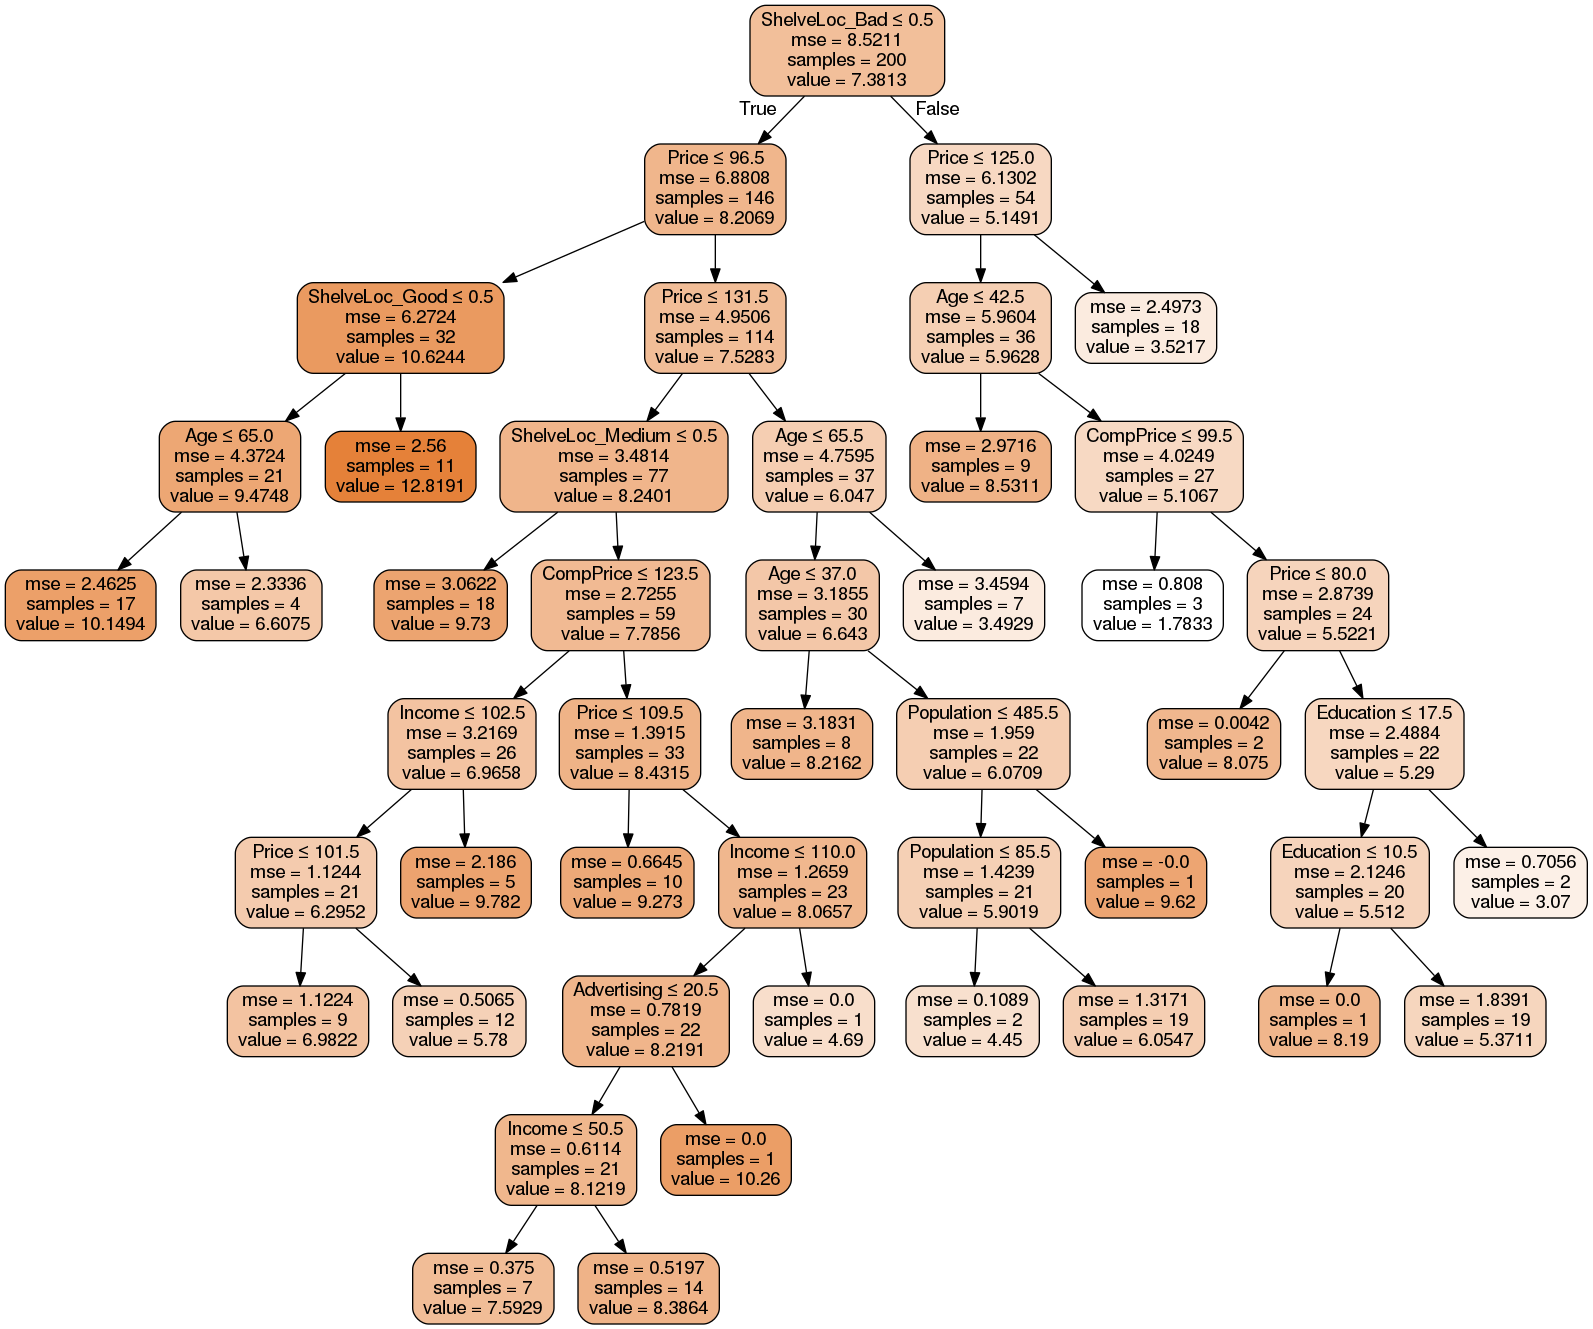

In [15]:
# Now lets plot out the regression tree use export_graphviz
dot_data = export_graphviz(tree_est, out_file='seat_tree.dot',feature_names=predictors,filled=True,
                           rounded=True, special_characters=True)

with open('seat_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

The first split is for shelf location. If the shelf loc is bad then price and age determine the next splits. If the shelf location is not bad then price and shelf loc = good determine the next split. We can take a look at the variable importances to see how they compare with the classification problem we looked at in the lab.

In [16]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
Price,0.345366
ShelveLoc_Bad,0.274929
Age,0.151491
ShelveLoc_Good,0.060222
CompPrice,0.051107
Income,0.047699
ShelveLoc_Medium,0.038894
Education,0.013718
Population,0.013318
Advertising,0.003255


As in the classification problem the price plays an improtant role in determining the sales but unlike the classification problem a bad shelveLoc and age are significant factors in determining the sale price.

## Compute Test Error Rate

In [18]:
mse = np.mean((tree_est.predict(X_test)-y_test)**2)
print("Test MSE = ", mse)

Test MSE =  13.2206974266


As mentioned in the labs sklearn does not offer a pruning method at this time. To implement this we would need to write a new method in the sklearn tree class that would remove stumps that contirbute little to the models reduction in RSS. For now, I skip this part of the question.

## Bagging Approach

In [30]:
# Build a bagger with 500 trees, technically we should find the number of trees necessary to allow the error rate
# to stabilize. Note we use the randomForestRegressor using all features per split (bagging) because RandomForests
# provides the feature importance whereas sklearn BaggingRegressor does not.
bagger = RandomForestRegressor(n_estimators=500, max_features='auto', random_state=0)
bag_est = bagger.fit(X_train, y_train.reshape(-1,))

bagging_mse = np.mean((bag_est.predict(X_test)-y_test)**2)
print('Bagging MSE = ', bagging_mse)

Bagging MSE =  10.9074754483


## Variable Importance

In [31]:
feature_importances = bag_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
Price,0.328872
ShelveLoc_Bad,0.171610
Age,0.109999
ShelveLoc_Good,0.084528
CompPrice,0.077051
Income,0.060974
Population,0.053243
Advertising,0.049288
Education,0.027212
ShelveLoc_Medium,0.022837


The same features we identified in a single decision tree are also important in the bagged ensemble of trees.

## Random Forests Approach

In [32]:
# Build forest with with 500 trees using the sqrt of the features
forest = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=0)
forest_est = forest.fit(X_train, y_train.reshape(-1,))

forest_mse = np.mean((forest_est.predict(X_test)-y_test)**2)
print('Random Forests MSE = ', forest_mse)

Random Forests MSE =  9.84120516081


In [33]:
# Repeat for p/2 for the max features to consider per split
forest = RandomForestRegressor(n_estimators=500, max_features=len(predictors)//2, random_state=0)
forest_est = forest.fit(X_train, y_train.reshape(-1,))

forest_mse = np.mean((forest_est.predict(X_test)-y_test)**2)
print('Random Forests MSE = ', forest_mse)

Random Forests MSE =  10.6279910014


So the Random Forests approach does improve over the bagging and we find that the sqrt of the number of the predictors provides a lower test error than simply taking the number of predictors divided by 2. Lastly lets look at the variable importances.

In [34]:
feature_importances = forest_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
Price,0.293095
ShelveLoc_Bad,0.140871
Age,0.109762
ShelveLoc_Good,0.092854
CompPrice,0.074096
Income,0.071210
Population,0.064599
Advertising,0.053374
ShelveLoc_Medium,0.037729
Education,0.035097
